In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import linear_model
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, r2_score
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR

In [2]:
pltrX = pd.read_csv('pltrDF-q2.csv')
pltrX = pltrX.loc[:, pltrX.columns != 'date']
pltrX = pltrX.loc[:, pltrX.columns != 'Unnamed: 0']
pltrX = pltrX.loc[:, pltrX.columns != 'daychange']
pltrX = pltrX.loc[:, pltrX.columns != 'anger']
pltrX = pltrX.loc[:, pltrX.columns != 'disgust']
pltrX = pltrX.loc[:, pltrX.columns != 'fear']
pltrX = pltrX.loc[:, pltrX.columns != 'joy']
pltrX = pltrX.loc[:, pltrX.columns != 'sadness']
pltrX = pltrX.loc[:, pltrX.columns != 'surprise']
pltrX = pltrX.loc[:, pltrX.columns != 'connectivity']
pltrX = pltrX.loc[:, pltrX.columns != 'avgdeg']

pltrX = pltrX.head(70)
pltrX

,size,edges,diameter,clustering,volume
0,567,537,14,0.000000,44970400
1,292,251,8,0.000231,29050400
2,269,224,10,0.000349,32732900
3,236,205,12,0.000000,32240000
4,231,182,9,0.010365,41313800
...,...,...,...,...,...
65,643,640,9,0.000086,35905500
66,720,738,13,0.000372,54082700
67,612,609,13,0.000433,68620800
68,793,824,12,0.000686,83913500


<Axes: >

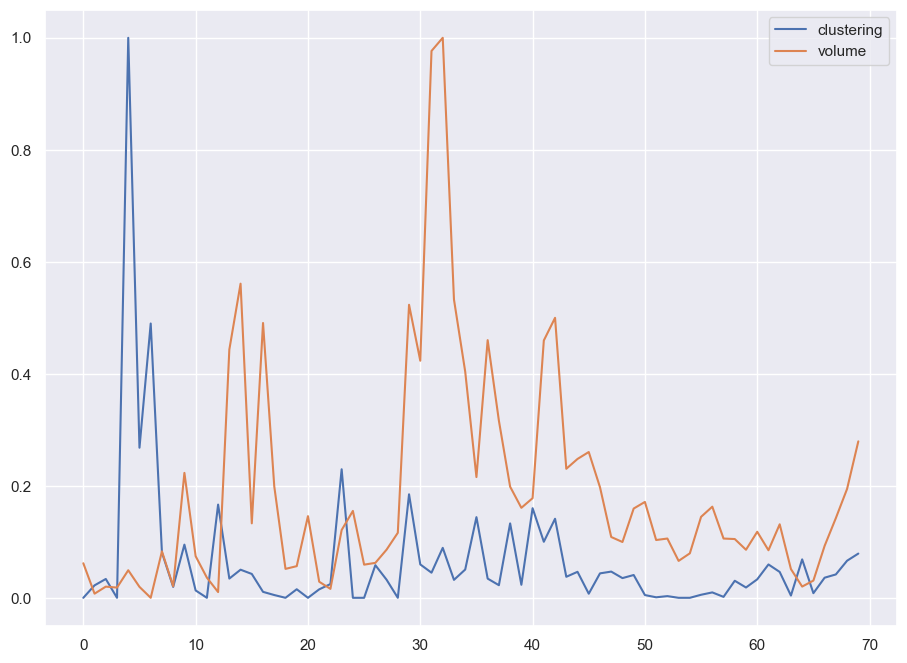

In [3]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
sns.set(rc={'figure.figsize':(11,8)})

pltrXs = scaler.fit_transform(pltrX)
pltrXs = pd.DataFrame(pltrXs,columns=['size','edges','diameter','clustering','volume'])
pltrXs[['clustering','volume']].plot()

In [4]:
for metric in pltrXs.columns:
    result = adfuller(pltrXs[[metric]])
    print('A-DF of metric',metric,'has p-value of',result[1])
    print()

A-DF of metric size has p-value of 0.00016152669391597134

A-DF of metric edges has p-value of 0.00015693096069322788

A-DF of metric diameter has p-value of 1.5540017322076188e-09

A-DF of metric clustering has p-value of 3.849636196619586e-07

A-DF of metric volume has p-value of 0.005795968404621083



In [6]:
#build the VAR model
model = VAR(pltrXs)
print(model.select_order(5))

pltr_model = model.fit(4)

pltr_model.summary()

<statsmodels.tsa.vector_ar.var_model.LagOrderResults object. Selected orders are: AIC -> 4, BIC -> 1, FPE -> 4, HQIC ->  2>


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 29, Aug, 2023
Time:                     13:40:18
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                   -20.5370
Nobs:                     66.0000    HQIC:                  -22.6440
Log likelihood:           429.427    FPE:                4.14676e-11
AIC:                     -24.0205    Det(Omega_mle):     1.04192e-11
--------------------------------------------------------------------
Results for equation size
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                 0.042416         0.052436            0.809           0.419
L1.size               4.655846         1.371003            3.396           0.001
L1.edges             -3.364666         1.306387           -2.

Text(0, 0.5, 'Volume (0,1)')

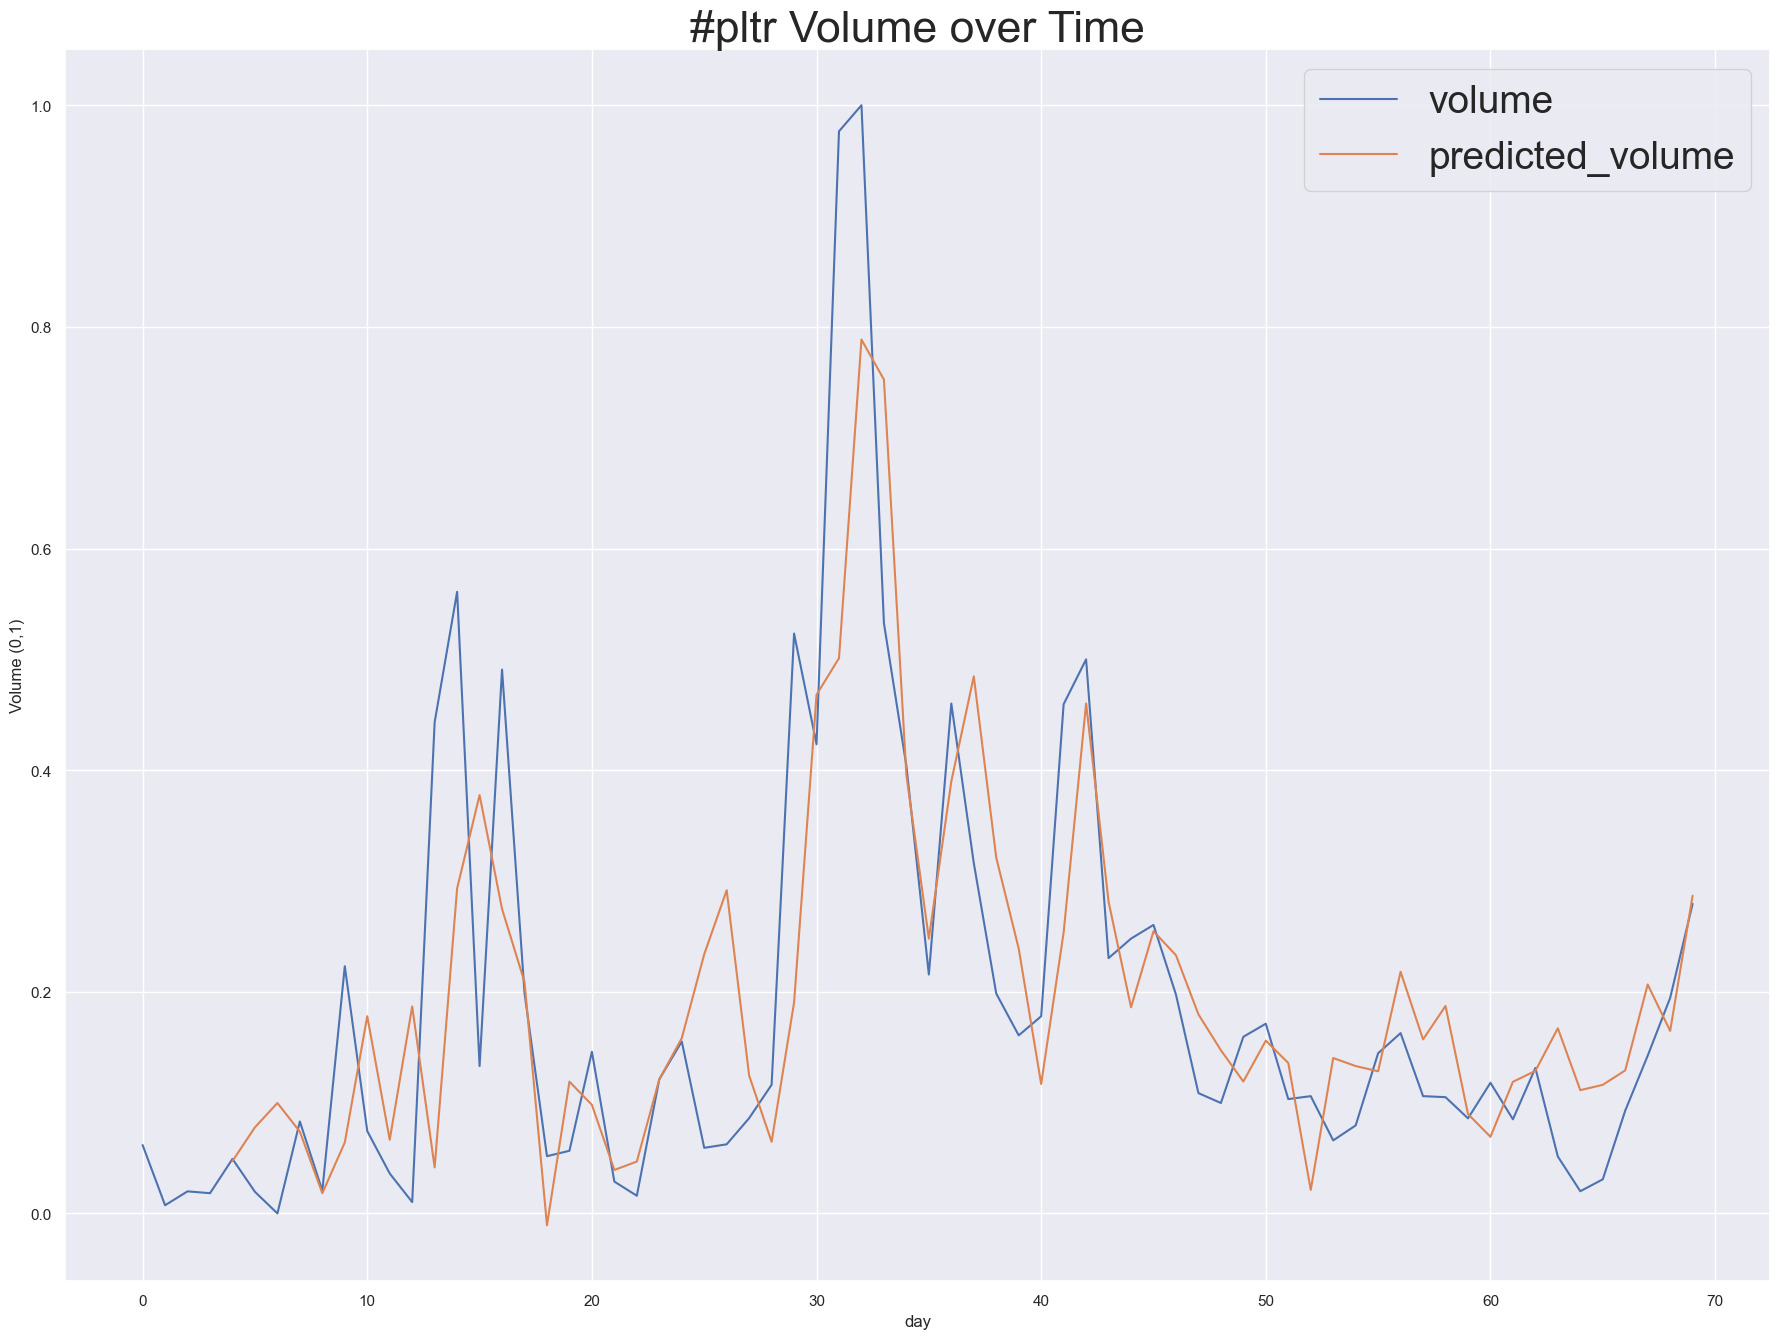

In [7]:
#forecast and plot

sns.set(rc={'figure.figsize':(22,16)})

pltrXs[['volume']].plot()
plt.plot(pltr_model.fittedvalues['volume'],label='predicted_volume')
plt.legend(fontsize='28')
plt.title('#pltr Volume over Time',fontsize=32)
plt.xlabel('day')
plt.ylabel('Volume (0,1)')

In [8]:
#test for causality
print(pltr_model.test_causality(4,0))
print(pltr_model.test_causality(4,1))
print(pltr_model.test_causality(4,2))
print(pltr_model.test_causality(4,3))
print(pltr_model.test_causality(4,4))

<statsmodels.tsa.vector_ar.hypothesis_test_results.CausalityTestResults object. H_0: size does not Granger-cause volume: fail to reject at 5% significance level. Test statistic: 1.153, critical value: 2.412>, p-value: 0.333>
<statsmodels.tsa.vector_ar.hypothesis_test_results.CausalityTestResults object. H_0: edges does not Granger-cause volume: fail to reject at 5% significance level. Test statistic: 0.970, critical value: 2.412>, p-value: 0.425>
<statsmodels.tsa.vector_ar.hypothesis_test_results.CausalityTestResults object. H_0: diameter does not Granger-cause volume: fail to reject at 5% significance level. Test statistic: 1.461, critical value: 2.412>, p-value: 0.215>
<statsmodels.tsa.vector_ar.hypothesis_test_results.CausalityTestResults object. H_0: clustering does not Granger-cause volume: fail to reject at 5% significance level. Test statistic: 0.100, critical value: 2.412>, p-value: 0.982>
<statsmodels.tsa.vector_ar.hypothesis_test_results.CausalityTestResults object. H_0: volu

In [9]:
print('pltr',mean_absolute_error(pltrXs[['volume']][4:],pltr_model.fittedvalues['volume']))

pltr 0.08879962201336038
